# NER with BERT

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## Install transformers

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
     |████████████████████████████████| 6.6 MB 50.6 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 490 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=70af9ab03f9692729cb7ccdc38c301953008c3c48f3c200042de902861f12aa7
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [4]:
import pandas as pd
import os

import os
import torch
import transformers

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from tqdm import tqdm, trange
from seqeval.metrics import classification_report, f1_score
from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup 

## Loading the MIT Restaurant Dataset

In [5]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=366724e1a842a2e20919fbc4d654f3e81ec9011897615bc0844e0442024b98a6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
import wget
import os

print('Downloading dataset...')

# The URL for the *training* examples.
url = 'https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio'

# Download the file (if we haven't already)
#if not os.path.exists('./restauranttrain.bio'):
wget.download(url, './restauranttrain.bio')

# The URL for the *test* examples.
url = 'https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio'

# Download the file (if we haven't already)
#if not os.path.exists('./restauranttest.bio'):
wget.download(url, './restauranttest.bio')

'./restauranttest.bio'

## Loading Kaggle dataset

In [7]:
!ls -ltr

total 908
drwxr-xr-x 1 root root   4096 Aug  3 20:21 sample_data
drwx------ 5 root root   4096 Aug  9 07:04 drive
-rw-r--r-- 1 root root 759757 Aug  9 07:05 restauranttrain.bio
-rw-r--r-- 1 root root 155722 Aug  9 07:05 restauranttest.bio


In [8]:
# This dataset is being taken from https://www.kaggle.com/code/casals90/ner-with-bert/notebook
!ls -ltr /content/drive/MyDrive/AmitKayal/ner.csv.zip
!unzip -q /content/drive/MyDrive/AmitKayal/ner.csv.zip ner.csv

-rw------- 1 root root 24383680 Aug  8 05:07 /content/drive/MyDrive/AmitKayal/ner.csv.zip


In [48]:
ner_dataset = os.path.join("/content/drive/MyDrive/AmitKayal/", "ner_dataset.csv")
output_path = os.path.join("/content/drive/MyDrive/AmitKayal/", "submissions")


In [10]:
ner_dataset_df = pd.read_csv(ner_dataset, encoding="latin1")
ner_dataset_df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


### Data analysis and Data cleaning

In [11]:
import ast


In [12]:
ner_dataset_df.rename(columns = {'Sentence #':'Sentence'}, inplace = True)

In [13]:
ner_dataset_df.head()

,Sentence,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [14]:
# ner_dataset["Sentence #"].fillna(method="ffill", inplace=True)
ner_dataset_df['Sentence'] =  ner_dataset_df["Sentence"].fillna(method="ffill")
ner_dataset_df.head(10)

,Sentence,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [15]:
## lets see unique values in Word column
ner_dataset_df.Word.unique()

array(['Thousands', 'of', 'demonstrators', ..., 'indicative', '3700',
       'Bermel'], dtype=object)

In [16]:
ner_dataset_df_word_unique = ner_dataset_df["Word"].unique()
print(ner_dataset_df["Word"].unique())

['Thousands' 'of' 'demonstrators' ... 'indicative' '3700' 'Bermel']


In [17]:
words_list = list(ner_dataset_df_word_unique)
print(f"There are {len(words_list)} words.")
words_list[:10]

There are 35178 words.


['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the']

In [18]:
tags_values = list(set(ner_dataset_df["Tag"].values))
print(f"There are {len(tags_values)} tag values.")
tags_values.append("PAD")
print(f"There are {len(tags_values)} tag values.")


There are 17 tag values.
There are 18 tag values.


In [19]:
# Python program to illustrate
# enumerate function
l1 = ["eat", "sleep", "repeat"]
s1 = "geek"
  
# creating enumerate objects
obj1 = enumerate(l1)
obj2 = enumerate(s1)
  
# print ("Return type:", type(obj1))
# print (list(enumerate(l1)))
  
# # changing start index to 2 from 0
# print (list(enumerate(s1, 2)))

In [20]:
tag2idx = {t: i for i, t in enumerate(tags_values)}
tag2idx

{'B-art': 3,
 'B-eve': 14,
 'B-geo': 10,
 'B-gpe': 6,
 'B-nat': 2,
 'B-org': 16,
 'B-per': 7,
 'B-tim': 5,
 'I-art': 4,
 'I-eve': 12,
 'I-geo': 8,
 'I-gpe': 13,
 'I-nat': 11,
 'I-org': 1,
 'I-per': 9,
 'I-tim': 0,
 'O': 15,
 'PAD': 17}

### Prepare dataset as BERT input

In [30]:
class SentenceGetter():
    def __init__(self, data):
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        
        self._split_sentence_and_labels()
        
    def _split_sentence_and_labels(self):
        self.sentences = []
        self.labels = []
        for sentence in self.grouped:
            tmp_sentence, tmp_tag = [], []
            for word, _, tag in sentence:
                tmp_sentence.append(word)
                tmp_tag.append(tag)

            self.sentences.append(tmp_sentence)
            self.labels.append(tmp_tag)

In [22]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    sentence_labels = []
    for word, label in zip(sentence, text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        sentence_labels.extend([label] * n_subwords)
    
    return tokenized_sentence, sentence_labels

In [28]:
class DataSet():
    def __init__(self, sentence_getter, tokenizer, max_len, tag2idx):
        # Tokenize sentences
        self.tokens = []
        self.labels = []
        for sentences, labels in zip(sentence_getter.sentences, sentence_getter.labels):
            tok, lab = tokenize_and_preserve_labels(sentences, labels)
            
            self.tokens.append(["[CLS]"] + tok)
            self.labels.append(["O"] + lab)
        
        # Convert tokens to ids
        self.input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in self.tokens], 
                                       maxlen=max_len, dtype="long", truncating="post", padding="post")
        
        # Convert tags to ids
        self.tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in self.labels], maxlen=max_len, 
                                  value=tag2idx["PAD"], padding="post", dtype="long", truncating="post")
        
        pad_tok = tokenizer.vocab["[PAD]"]
        sep_tok = tokenizer.vocab["[SEP]"]
        o_lab = tag2idx["O"]
        # Adding [SEP] and O for mark the end of sentence or nothing for splited sentences
        for voc_ids, tag_ids in zip(self.input_ids, self.tags):
            if voc_ids[-1] == pad_tok:
                continue
            else:
                voc_ids[-1] = sep_tok
                tag_ids[-1] = o_lab

        # Place a mask (zero) over the padding tokens
        self.attention_masks = [[float(i != 0.0) for i in ii] for ii in self.input_ids]

#### Download BERT tokenizer

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [35]:
sentence_getter = SentenceGetter(ner_dataset_df)
dataset = DataSet(sentence_getter, tokenizer, 32, tag2idx)

### Split data into train and validation

In [36]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(dataset.input_ids, dataset.tags,
                                                            random_state=2018, test_size=0.1)

tr_masks, val_masks, _, _ = train_test_split(dataset.attention_masks, dataset.input_ids,
                                             random_state=2018, test_size=0.1)

In [37]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

**You can use the plain tensors as X_train and y_train, if you are able to load them completely (and push to the GPU without sacrificing too much memory).
The Dataset is abstraction to be able to load and process each sample of your dataset lazily, while the DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc.**
- Refer the https://pytorch.org/tutorials/beginner/data_loading_tutorial.html for more details

In [38]:
batch_size = 32

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

### Donwload pre-trained BERT model

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [41]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Model fine-tuning

In [42]:
full_finetuning = True
if full_finetuning:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


#### Create the learning rate scheduler

In [43]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

#### Training and validation

In [44]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [47]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    model.train()
    
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Clear previously gradients.
        model.zero_grad()
        
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        total_loss += loss.item()
        # Clip the norm of the gradient (for prevent "exploding gradients")
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # Update parameters
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)
    
    # ========================================
    #               Validation
    # ========================================
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Not to compute or store gradients,
        with torch.no_grad():
            # Forward pass.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    # Compute statistics
    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    
    pred_tags = [tags_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tags_values[l_i] != "PAD"]
    valid_tags = [tags_values[l_i] for l in true_labels
                                  for l_i in l if tags_values[l_i] != "PAD"]
    
    # Show values
    print(f"Validation loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy / nb_eval_steps}")
    # print(f"Classification report {classification_report(valid_tags, pred_tags)}")
    # print(f"Validation F1-Score: {f1_score(pred_tags, valid_tags)}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.05971140044985037


Epoch:  33%|███▎      | 1/3 [03:12<06:25, 192.55s/it]

Validation loss: 0.09237743427356084
Validation Accuracy: 0.9723763020833334
Average train loss: 0.051832957567441364


Epoch:  67%|██████▋   | 2/3 [06:16<03:07, 187.56s/it]

Validation loss: 0.09237743427356084
Validation Accuracy: 0.9723763020833334
Average train loss: 0.05200585803835811


Epoch: 100%|██████████| 3/3 [09:19<00:00, 186.39s/it]

Validation loss: 0.09237743427356084
Validation Accuracy: 0.9723763020833334


In [52]:
model_path = os.path.join(output_path, "trained_bert.pt")
torch.save(model.state_dict(), model_path)

### Plot learning curve

In [53]:
def plot_learning_curve(training_loss, validation_loss):
    plt.figure(figsize=(12, 8))
    
    plt.plot(training_loss, 'b-o', label="training loss")
    plt.plot(validation_loss, 'r-o', label="validation loss")

    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

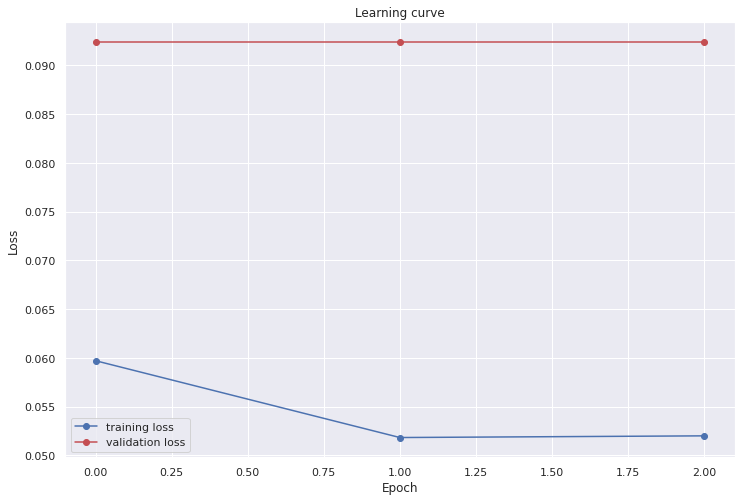

In [54]:
plot_learning_curve(loss_values, validation_loss_values)

In [ ]:
### Predictions

In [55]:
def prediction(sentence):
    tokenized_sentence = tokenizer.encode(sentence)
    input_ids = torch.tensor([tokenized_sentence]).cuda()

    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tags_values[label_idx])
            new_tokens.append(token)
   
    for token, label in zip(new_tokens, new_labels):
        print("{}\t{}".format(label, token))

In [56]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere."""

prediction(test_sentence)

O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]


In [57]:
test_sentence = "UK Prime Minister Boris Johnson is expected to explain any changes to lockdown measures and launch a threat level alert system."

prediction(test_sentence)

O	[CLS]
B-org	UK
B-per	Prime
I-per	Minister
I-per	Boris
I-per	Johnson
O	is
O	expected
O	to
O	explain
O	any
O	changes
O	to
O	lockdown
O	measures
O	and
O	launch
O	a
O	threat
O	level
O	alert
O	system
O	.
O	[SEP]


In [58]:
test_sentence = "In South Korea, renewed restrictions are imposed after a series of transmissions linked to Seoul's leisure district."

prediction(test_sentence)

O	[CLS]
O	In
B-geo	South
I-geo	Korea
O	,
O	renewed
O	restrictions
O	are
O	imposed
O	after
O	a
O	series
O	of
O	transmissions
O	linked
O	to
B-geo	Seoul
O	'
O	s
O	leisure
O	district
O	.
O	[SEP]


In [59]:
test_sentence = "In West Bengal, renewed restrictions are imposed after a series of transmissions linked to Seoul's leisure district."

prediction(test_sentence)

O	[CLS]
O	In
B-geo	West
I-geo	Bengal
O	,
O	renewed
O	restrictions
O	are
O	imposed
O	after
O	a
O	series
O	of
O	transmissions
O	linked
O	to
B-geo	Seoul
O	'
O	s
O	leisure
O	district
O	.
O	[SEP]


In [61]:
test_sentence = "In Purulia, renewed restrictions are imposed after a series of transmissions linked to bakura's leisure district."

prediction(test_sentence)

O	[CLS]
O	In
B-geo	Purulia
O	,
O	renewed
O	restrictions
O	are
O	imposed
O	after
O	a
O	series
O	of
O	transmissions
O	linked
O	to
B-geo	bakura
O	'
O	s
O	leisure
O	district
O	.
O	[SEP]


# NER with Huggingface

**This is based on https://huggingface.co/docs/transformers/tasks/token_classification**

- NER needs extensive data for training.
- But we don’t need to worry, as CONLL_03 comes to the rescue!!!
- CoNLL-2003 consists of a large annotated and unannotated dataset for training , testing and validation.
- The NER dataset should contain two columns separated by a single space. The first column consists of a single word followed by the Named Entity Tag in the second column.

Let’s take an example :
- Let the text be “George Washington went to Washington.
- So the format would be :
  - B -> stands for Beginning
  - I -> stands for intermediate
  - So, if any phrase consists of related words, then we use the annotations.

```
George B-PER
Washington I-PER
went O
to O
Washington B-LOC
```



```
Here, George is the first name, and Washington is the last name.

# So, for NER to know that these types of words should come together 
while running the model on a piece of text, we prefix such words 
with B- or I- followed by the tag (PER, LOC, ORG, etc.) while creating our dataset.

# Also, it will help or model to differentiate between 2 similar entities.
Like in the above example, Washington in George Washington is the last name 
and also a location.
```

- Now, let us explore another example and make it clear.
- Text example: "The United States of America"

```
United B-LOC
States I-LOC
of I-LOC
America I-LOC
```



In [5]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 4.1 MB/s 
     |████████████████████████████████| 141 kB 71.9 MB/s 
     |████████████████████████████████| 212 kB 68.4 MB/s 
     |████████████████████████████████| 115 kB 72.3 MB/s 
     |████████████████████████████████| 127 kB 68.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [6]:
from datasets import load_dataset

##  The CoNLL-2003 dataset

In [7]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

- we can see the dataset contains labels for the three tasks NER, POS, and chunking
- 

In [8]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [4]:
raw_datasets['train'][0]

{'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'id': '0',
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.']}

The labels are already coded as integer ids to be easily usable by our model, but the correspondence with the actual categories is stored in the features of the dataset:

In [8]:
raw_datasets["train"]

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [6]:
raw_datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

So for the NER tags, 0 corresponds to 'O', 1 to 'B-PER' etc... On top of the 'O' (which means no special entity), there are four labels for NER here, each prefixed with 'B-' (for beginning) or 'I-' (for intermediate), that indicate if the token is the first one for the current group with the label or not:

    'PER' for person
    'ORG' for organization
    'LOC' for location
    'MISC' for miscellaneous

In [11]:
## here is how we can 
raw_datasets["train"].features[f"ner_tags"].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [7]:
raw_datasets['train'][0]['tokens']

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [8]:
# Since we want to perform named entity recognition, we will look at the NER tags:
raw_datasets["train"][0]["ner_tags"]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

- pos_tags: a list of classification labels (int). Full tagset with indices:

```
{'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'CC': 10, 'CD': 11, 'DT': 12,
 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'LS': 19, 'MD': 20, 'NN': 21, 'NNP': 22, 'NNPS': 23,
 'NNS': 24, 'NN|SYM': 25, 'PDT': 26, 'POS': 27, 'PRP': 28, 'PRP$': 29, 'RB': 30, 'RBR': 31, 'RBS': 32, 'RP': 33,
 'SYM': 34, 'TO': 35, 'UH': 36, 'VB': 37, 'VBD': 38, 'VBG': 39, 'VBN': 40, 'VBP': 41, 'VBZ': 42, 'WDT': 43,
 'WP': 44, 'WP$': 45, 'WRB': 46}
 ```

- chunk_tags: a list of classification labels (int). Full tagset with indices:


```
{'O': 0, 'B-ADJP': 1, 'I-ADJP': 2, 'B-ADVP': 3, 'I-ADVP': 4, 'B-CONJP': 5, 'I-CONJP': 6, 'B-INTJ': 7, 'I-INTJ': 8,
 'B-LST': 9, 'I-LST': 10, 'B-NP': 11, 'I-NP': 12, 'B-PP': 13, 'I-PP': 14, 'B-PRT': 15, 'I-PRT': 16, 'B-SBAR': 17,
 'I-SBAR': 18, 'B-UCP': 19, 'I-UCP': 20, 'B-VP': 21, 'I-VP': 22}
```
- ner_tags: a list of classification labels (int). Full tagset with indices:

```
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

```
More details can be found from https://huggingface.co/datasets/conll2003

**Lets now try to get some more view on dataset and their tag values.**

In [12]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

In [13]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [15]:
show_random_elements(raw_datasets["train"])

,id,tokens,pos_tags,chunk_tags,ner_tags
0,10823,"[The, devastating, opening, pair, of, Jayasuriya, and, Romesh, Kaluwitharana, shared, a, fine, first, wicket, stand, of, 129, to, the, delight, of, the, 25,000, fans, .]","[DT, VBG, NN, NN, IN, NNP, CC, NNP, NNP, VBD, DT, JJ, JJ, NN, NN, IN, CD, TO, DT, NN, IN, DT, CD, NNS, .]","[B-NP, I-NP, I-NP, I-NP, B-PP, B-NP, I-NP, I-NP, I-NP, B-VP, B-NP, I-NP, I-NP, I-NP, I-NP, B-PP, B-NP, B-PP, B-NP, I-NP, B-PP, B-NP, I-NP, I-NP, O]","[O, O, O, O, O, B-PER, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,2347,"[2., Fernanda, Ribeiro, (, Portugal, ), 14:49.81]","[CD, NNP, NNP, (, NNP, ), CD]","[B-NP, I-NP, I-NP, O, B-NP, O, B-NP]","[O, B-PER, I-PER, O, B-LOC, O, O]"
2,13200,"[-, High, Court, officials, have, unearthed, police-run, human, cages, at, Tando, Allahyar, near, Hyderabad, .]","[:, NNP, NNP, NNS, VBP, VBD, JJ, JJ, NNS, IN, NNP, NNP, IN, NNP, .]","[O, B-NP, I-NP, I-NP, B-VP, I-VP, B-NP, I-NP, I-NP, B-PP, B-NP, I-NP, B-PP, B-NP, O]","[O, O, O, O, O, O, O, O, O, O, B-LOC, I-LOC, O, B-LOC, O]"
3,9622,"[NOTES, -, Sales, and, operating, profit, are, given, in, millions, of, guilders, .]","[NNS, :, NNS, CC, NN, NN, VBP, VBN, IN, NNS, IN, NNS, .]","[B-NP, O, B-NP, O, B-NP, I-NP, B-VP, I-VP, B-PP, B-NP, B-PP, B-NP, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,4922,"[league, soccer, match, on, Sunday, :]","[NN, NN, NN, IN, NNP, :]","[B-NP, I-NP, I-NP, B-PP, B-NP, O]","[O, O, O, O, O, O]"
5,8662,"[After, two, seasons, in, the, second, division, and, after, taking, on, half, a, dozen, new, recruits, this, season, ,, some, of, whom, do, not, speak, a, word, of, French, ,, Marseille, are, not, playing, with, any, fluidity, .]","[IN, CD, NNS, IN, DT, JJ, NN, CC, IN, VBG, IN, NN, DT, NN, JJ, NNS, DT, NN, ,, DT, IN, WP, VBP, RB, VB, DT, NN, IN, JJ, ,, NNP, VBP, RB, VBG, IN, DT, NN, .]","[B-PP, B-NP, I-NP, B-PP, B-NP, I-NP, I-NP, O, B-PP, B-VP, B-PP, B-NP, B-NP, I-NP, B-NP, I-NP, B-NP, I-NP, O, B-NP, B-PP, B-NP, B-VP, I-VP, I-VP, B-NP, I-NP, B-PP, B-NP, I-NP, I-NP, B-VP, I-VP, I-VP, B-PP, B-NP, I-NP, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-MISC, O, B-ORG, O, O, O, O, O, O, O]"
6,12286,"[Tanya, Dubnicoff, (, Canada, ), beat, Michelle, Ferris, (, Australia, ), 2-0, ,]","[NNP, NNP, (, NNP, ), VB, NNP, NNP, (, NNP, ), CD, ,]","[B-NP, I-NP, O, B-NP, O, B-VP, B-NP, I-NP, O, B-NP, O, B-NP, O]","[B-PER, I-PER, O, B-LOC, O, O, B-PER, I-PER, O, B-LOC, O, O, O]"
7,638,"[Newcombe, has, selected, Wimbledon, semifinalist, Jason, Stoltenberg, ,, Patrick, Rafter, ,, Mark, Philippoussis, ,, and, Olympic, doubles, champions, Todd, Woodbridge, and, Mark, Woodforde, to, face, the, Croatians, .]","[NNP, VBZ, VBN, NNP, NN, NNP, NNP, ,, NNP, NNP, ,, NNP, NNP, ,, CC, JJ, VBZ, NNS, NNP, NNP, CC, NNP, NNP, TO, VB, DT, NNPS, .]","[B-NP, B-VP, I-VP, B-NP, I-NP, I-NP, I-NP, O, B-NP, I-NP, O, B-NP, I-NP, O, O, B-NP, B-VP, B-NP, I-NP, I-NP, I-NP, I-NP, I-NP, B-VP, I-VP, B-NP, I-NP, O]","[B-PER, O, O, B-MISC, O, B-PER, I-PER, O, B-PER, I-PER, O, B-PER, I-PER, O, O, B-MISC, O, O, B-PER, I-PER, O, B-PER, I-PER, O, O, O, B-MISC, O]"
8,11042,"[--, Sydney, Newsroom, 61-2, 9373-1800]","[:, NNP, NNP, NN, CD]","[B-NP, I-NP, I-NP, I-NP, I-NP]","[O, B-ORG, I-ORG, O, O]"
9,1534,"[We, will, be, guests, of, the, Kennedys, ,, "", said, Frank, Quilter, ,, one, of, the, two, who, have, been, invited, to, Chicago, .]","[PRP, MD, VB, NNS, IN, DT, NNPS, ,, "", VBD, NNP, NNP, ,, CD, IN, DT, CD, WP, VBP, VBN, VBN, TO, NNP, .]","[B-NP, B-VP, I-VP, B-NP, B-PP, B-NP, I-NP, O, O, B-VP, B-NP, I-NP, O, B-NP, B-PP, B-NP, I-NP, B-NP, B-VP, I-VP, I-VP, B-PP, B-NP, O]","[O, O, O, O, O, O, B-PER, O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, B-LOC, O]"


In [17]:
show_random_elements(raw_datasets["validation"])

,id,tokens,pos_tags,chunk_tags,ner_tags
0,3142,"[Clinton, said, Iraqi, military, forces, overran, the, city, of, Arbil, ,, which, has, been, held, since, 1994, by, Kurdish, rebels, who, Baghdad, says, are, backed, by, Iran, .]","[NNP, VBD, JJ, JJ, NNS, VBD, DT, NN, IN, NNP, ,, WDT, VBZ, VBN, VBN, IN, CD, IN, JJ, NNS, WP, NNP, VBZ, VBP, VBN, IN, NNP, .]","[B-NP, B-VP, B-NP, I-NP, I-NP, B-VP, B-NP, I-NP, B-PP, B-NP, O, B-NP, B-VP, I-VP, I-VP, B-PP, B-NP, B-PP, B-NP, I-NP, B-NP, B-NP, B-VP, B-VP, I-VP, B-PP, B-NP, O]","[B-PER, O, B-MISC, O, O, O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, B-MISC, O, O, B-LOC, O, O, O, O, B-LOC, O]"
1,30,"[LONDON, 1996-08-30]","[NNP, CD]","[B-NP, I-NP]","[B-LOC, O]"
2,1945,"[LONDON, 1996-08-31]","[NNP, NNP]","[B-NP, I-NP]","[B-LOC, O]"
3,1551,"[Barentsburg, is, an, even, grimmer, place, ,, a, run-down, testament, to, the, hardships, of, the, new, Russia, .]","[NN, VBZ, DT, RB, RBR, NN, ,, DT, JJ, NN, TO, DT, NNS, IN, DT, JJ, NNP, .]","[B-NP, B-VP, B-NP, I-NP, B-ADJP, B-NP, O, B-NP, I-NP, I-NP, B-PP, B-NP, I-NP, B-PP, B-NP, I-NP, I-NP, O]","[B-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O]"
4,1903,"[20., Paul, Broadhurst, 176,780]","[CD, NNP, NNP, CD]","[B-NP, I-NP, I-NP, B-NP]","[O, B-PER, I-PER, O]"
5,2459,"[SATURDAY, ,, AUGUST, 31, SCHEDULE]","[NNP, ,, NN, CD, NNP]","[B-NP, O, B-NP, I-NP, I-NP]","[O, O, O, O, O]"
6,3011,"[Chinese, authorities, appeared, to, be, using, administrative, punishment, more, frequently, to, take, dissidents, out, of, circulation, without, having, to, go, through, a, more, complicated, judicial, process, to, impose, criminal, sentences, ,, Western, diplomats, have, said, .]","[JJ, NNS, VBD, TO, VB, VBG, JJ, NN, RBR, RB, TO, VB, NNS, IN, IN, NN, IN, VBG, TO, VB, IN, DT, RBR, JJ, JJ, NN, TO, VB, JJ, NNS, ,, JJ, NNS, VBP, VBN, .]","[B-NP, I-NP, B-VP, I-VP, I-VP, I-VP, B-NP, I-NP, B-ADVP, I-ADVP, B-VP, I-VP, B-NP, B-PP, B-PP, B-NP, B-PP, B-VP, I-VP, I-VP, B-PP, B-NP, I-NP, I-NP, I-NP, I-NP, B-VP, I-VP, B-NP, I-NP, O, B-NP, I-NP, B-VP, I-VP, O]","[B-MISC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-MISC, O, O, O, O]"
7,1082,"[The, policy-making, FOMC, is, to, meet, on, Sept, .]","[DT, JJ, NNP, VBZ, TO, VB, IN, NNP, .]","[B-NP, I-NP, I-NP, B-VP, B-VP, I-VP, B-PP, B-NP, O]","[O, O, B-ORG, O, O, O, O, O, O]"
8,908,"[They, also, said, rebel, fighters, had, looted, medicines, from, the, local, hospital, .]","[PRP, RB, VBD, NN, NNS, VBD, VBN, NNS, IN, DT, JJ, NN, .]","[B-NP, B-ADVP, B-VP, B-NP, I-NP, B-VP, I-VP, B-NP, B-PP, B-NP, I-NP, I-NP, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O]"
9,766,"[BRITAIN, -, Gilts, struggled, off, the, day, 's, lows, but, ended, 10/32, down, on, the, day, .]","[NNP, :, NNS, VBD, IN, DT, NN, POS, NNS, CC, VBD, CD, IN, IN, DT, NN, .]","[B-NP, O, B-NP, B-VP, B-PP, B-NP, I-NP, B-NP, I-NP, O, B-VP, B-NP, B-PP, B-PP, B-NP, I-NP, O]","[B-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


### Preprocessing the data


- we need to preprocess them. This is done by a 🤗 Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.
- we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:
  - we get a tokenizer that corresponds to the model architecture we want to use
  - we download the vocabulary used when pretraining this specific checkpoint.

In [15]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [13]:
from transformers import AutoTokenizer
import transformers

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

**The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the huggingface Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.**

In [22]:
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [26]:
tok_sample = tokenizer("Hello, this is Amit Kayal and I am testing hugging face NER!")

In [25]:
tok_sample

{'input_ids': [101, 7592, 1010, 2023, 2003, 26445, 2102, 10905, 2389, 1998, 1045, 2572, 5604, 17662, 2227, 11265, 2099, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**If, as is the case here, your inputs have already been split into words, you should pass the list of words to your tokenzier with the argument is_split_into_words=True:**

In [29]:
tokenizer(["Hello", ",", "this", "is", "Amit", "Kayal", "and", "I", "am", "testing","hugging", "face","NER" ,"!"], is_split_into_words=True)

{'input_ids': [101, 7592, 1010, 2023, 2003, 26445, 2102, 10905, 2389, 1998, 1045, 2572, 5604, 17662, 2227, 11265, 2099, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
example = raw_datasets["train"][4]
example['tokens']

['Germany',
 "'s",
 'representative',
 'to',
 'the',
 'European',
 'Union',
 "'s",
 'veterinary',
 'committee',
 'Werner',
 'Zwingmann',
 'said',
 'on',
 'Wednesday',
 'consumers',
 'should',
 'buy',
 'sheepmeat',
 'from',
 'countries',
 'other',
 'than',
 'Britain',
 'until',
 'the',
 'scientific',
 'advice',
 'was',
 'clearer',
 '.']

In [32]:
## Now, our above data seems to be already splitted into word and hence we have to pass special variable in tokenizer to indicate that. 
## the attention mask has set to 1 for all the token values and we have not used padding here. For PAD token the attention mask will have value of 0.
tokenizer(example['tokens'], is_split_into_words=True)

{'input_ids': [101, 2762, 1005, 1055, 4387, 2000, 1996, 2647, 2586, 1005, 1055, 15651, 2837, 14121, 1062, 9328, 5804, 2056, 2006, 9317, 10390, 2323, 4965, 8351, 4168, 4017, 2013, 3032, 2060, 2084, 3725, 2127, 1996, 4045, 6040, 2001, 24509, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [34]:
## here we are converting token Id to token values. The tokenizer output has two key as shown above.
print(tokenizer.convert_ids_to_tokens(tokenizer(example['tokens'], is_split_into_words=True)["input_ids"]))

['[CLS]', 'germany', "'", 's', 'representative', 'to', 'the', 'european', 'union', "'", 's', 'veterinary', 'committee', 'werner', 'z', '##wing', '##mann', 'said', 'on', 'wednesday', 'consumers', 'should', 'buy', 'sheep', '##me', '##at', 'from', 'countries', 'other', 'than', 'britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.', '[SEP]']


Here the words "Zwingmann" and "sheepmeat" have been split in three subtokens.
- 'sheep', '##me', '##at'
- 'z', '##wing', '##mann'

**Observations:**
-  we need to do some processing on our labels as the input ids returned by the tokenizer are longer than the lists of labels our dataset contain.
  - some special tokens might be added (we can a [CLS] and a [SEP] above)
  - possible splits of words in multiple tokens:

In [51]:
print(f"Original Length:{len(example['tokens'])} and Length after wordpiece tokenization by BERT:{len(tokenizer.convert_ids_to_tokens(tokenizer(example['tokens'], is_split_into_words=True)['input_ids']))}")
#  and Length after wordpiece tokenization:{len(tokenizer.convert_ids_to_tokens(tokenizer(example['tokens'], is_split_into_words=True)["input_ids"]))}")

Original Length:31 and Length after wordpiece tokenization by BERT:39


In [18]:
print(f"Original Length:{len(example['ner_tags'])} and Length after wordpiece tokenization by BERT:{len(tokenizer.convert_ids_to_tokens(tokenizer(example['tokens'], is_split_into_words=True)['input_ids']))}")


Original Length:31 and Length after wordpiece tokenization by BERT:39


In [56]:
tokenizer(example['tokens'], is_split_into_words=True)

{'input_ids': [101, 2762, 1005, 1055, 4387, 2000, 1996, 2647, 2586, 1005, 1055, 15651, 2837, 14121, 1062, 9328, 5804, 2056, 2006, 9317, 10390, 2323, 4965, 8351, 4168, 4017, 2013, 3032, 2060, 2084, 3725, 2127, 1996, 4045, 6040, 2001, 24509, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

- As we can see, word_ids returns a list with the same number of elements as our processed input ids, mapping special tokens to None and all other tokens to their respective word. This way, we can align the labels with the processed input ids.


In [57]:
tokenizer(example['tokens'], is_split_into_words=True).word_ids()

[None,
 0,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 7,
 8,
 9,
 10,
 11,
 11,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 18,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 None]

**So, now as we see after tokenization length has been increased and but our ner_tag lenth is of original ones. So we need to map the tag for extra ones.**

In [19]:
example['ner_tags']

[5,
 0,
 0,
 0,
 0,
 3,
 4,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [21]:
tokenized_input = tokenizer(example['tokens'], is_split_into_words=True)

In [22]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

39 39


In [23]:
aligned_labels

[-100,
 5,
 0,
 0,
 0,
 0,
 0,
 3,
 4,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -100]

**Here we set the labels of all special tokens to -100 (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from. Another strategy is to set the label only on the first token obtained from a given word, and give a label of -100 to the other subtokens from the same word. We propose the two strategies here, just change the value of the following flag:**

In [24]:
label_all_tokens = True

- We feed them to the tokenizer with the argument truncation=True (to truncate texts that are bigger than the maximum size allowed by the model) 
- and is_split_into_words=True (as seen above)

In [26]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [28]:
tokenize_and_align_labels(raw_datasets['train'][:3])

{'input_ids': [[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], [101, 2848, 13934, 102], [101, 9371, 2727, 1011, 5511, 1011, 2570, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100], [-100, 1, 2, -100], [-100, 5, 0, 0, 0, 0, 0, -100]]}

- To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command.

In [29]:
tokenized_datasets = raw_datasets.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

- results are automatically cached by the 🤗 Datasets library
- Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data).
- we passed batched=True to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model


In [31]:
label_list = raw_datasets["train"].features[f"{task}_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [30]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

In [32]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

**The warning is telling us we are throwing away some weights (the vocab_transform and vocab_layer_norm layers) and randomly initializing some other (the pre_classifier and classifier layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.**

In [33]:
model_name = model_checkpoint.split("/")[-1]
model_name

'distilbert-base-uncased'

**First you have to store your authentication token from the Hugging Face website (sign up here if you haven't already!) then execute the following cell and input your username and password:**

In [34]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store



To instantiate a Trainer, we will need to define three more things. 
- The most important is the TrainingArguments, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:
- The last argument to setup everything so we can push the model to the Hub regularly during training.


In [36]:
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

- DataCollatorForTokenClassification to create a batch of examples. It will also dynamically pad your text and labels to the length of the longest element in its batch, so they are a uniform length. While it is possible to pad your text in the tokenizer function by setting padding=True, dynamic padding is more efficient

In [37]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

- The last thing to define for our Trainer is how to compute the metrics from the predictions. 

In [39]:
from datasets import load_dataset, load_metric

In [40]:
metric = load_metric("seqeval")

Now, lets understand the seqeval a bit to see how it calculate accuracy.

In [46]:
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
f1_score(y_true, y_pred)

0.5

In [47]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [48]:
from seqeval.scheme import IOB2
print(classification_report(y_true, y_pred, mode='strict', scheme=IOB2))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [53]:
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [54]:
example[f"{task}_tags"]

[5,
 0,
 0,
 0,
 0,
 3,
 4,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [51]:
len(example[f"{task}_tags"])

31

In [49]:
labels = [label_list[i] for i in example[f"{task}_tags"]]
labels

['B-LOC',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [52]:
len(labels)

31

In [55]:
metric.compute(predictions=[labels], references=[labels])

{'LOC': {'f1': 1.0, 'number': 2, 'precision': 1.0, 'recall': 1.0},
 'ORG': {'f1': 1.0, 'number': 1, 'precision': 1.0, 'recall': 1.0},
 'PER': {'f1': 1.0, 'number': 1, 'precision': 1.0, 'recall': 1.0},
 'overall_accuracy': 1.0,
 'overall_f1': 1.0,
 'overall_precision': 1.0,
 'overall_recall': 1.0}

So we will need to do a bit of post-processing on our predictions
- select the predicted index (with the maximum logit) for each token
- convert it to its string label
- ignore everywhere we set a label of -100

**The following function does all this post-processing on the result of Trainer.evaluate (which is a namedtuple containing predictions and labels) before applying the metric:**

In [56]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

- Note that we drop the precision/recall/f1 computed for each category and only focus on the overall precision/recall/f1/accuracy.
- Then we just need to pass all of this along with our datasets to the Trainer: 

In [57]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner into local empty directory.


We can now finetune our model by just calling the train method:

In [58]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14041
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2634
The following columns in the training set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: ner_tags, chunk_tags, tokens, pos_tags, id. If ner_tags, chunk_tags, tokens, pos_tags, id are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.245600,0.068338,0.915085,0.922251,0.918654,0.981365
2,0.054200,0.060892,0.922711,0.933550,0.928099,0.982874
3,0.029300,0.061387,0.928832,0.938807,0.933793,0.983971


Saving model checkpoint to distilbert-base-uncased-finetuned-ner/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-ner/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-ner/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-ner/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-ner/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-ner/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-ner/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: ner_tags, chunk_tags, tokens, pos_tags, id. If ner_tags, chunk_tags, tokens, pos_tags, id are not expected by `DistilBertFor

TrainOutput(global_step=2634, training_loss=0.08672869775724303, metrics={'train_runtime': 208.9114, 'train_samples_per_second': 201.631, 'train_steps_per_second': 12.608, 'total_flos': 510709003547400.0, 'train_loss': 0.08672869775724303, 'epoch': 3.0})

In [59]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3250
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: ner_tags, chunk_tags, tokens, pos_tags, id. If ner_tags, chunk_tags, tokens, pos_tags, id are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.


{'epoch': 3.0,
 'eval_accuracy': 0.9839706419686403,
 'eval_f1': 0.9337932569266718,
 'eval_loss': 0.06138650327920914,
 'eval_precision': 0.9288323187603763,
 'eval_recall': 0.9388074728716859,
 'eval_runtime': 5.011,
 'eval_samples_per_second': 648.57,
 'eval_steps_per_second': 40.71}

**The evaluate method allows you to evaluate again on the evaluation dataset or on another dataset:**

To get the precision/recall/f1 computed for each category now that we have finished training, we can apply the same function as before on the result of the predict method:


In [60]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

***** Running Prediction *****
  Num examples = 3250
  Batch size = 16
The following columns in the test set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: ner_tags, chunk_tags, tokens, pos_tags, id. If ner_tags, chunk_tags, tokens, pos_tags, id are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.


{'LOC': {'f1': 0.9556650246305418,
  'number': 2618,
  'precision': 0.9481203007518797,
  'recall': 0.9633307868601986},
 'MISC': {'f1': 0.8253839935327405,
  'number': 1231,
  'precision': 0.8213998390989542,
  'recall': 0.8294069861900893},
 'ORG': {'f1': 0.9087837837837838,
  'number': 2056,
  'precision': 0.9018199233716475,
  'recall': 0.9158560311284046},
 'PER': {'f1': 0.9759789404409345,
  'number': 3034,
  'precision': 0.9743758212877792,
  'recall': 0.977587343441002},
 'overall_accuracy': 0.9839706419686403,
 'overall_f1': 0.9337932569266718,
 'overall_precision': 0.9288323187603763,
 'overall_recall': 0.9388074728716859}

In [61]:
trainer.push_to_hub()

Saving model checkpoint to distilbert-base-uncased-finetuned-ner
Configuration saved in distilbert-base-uncased-finetuned-ner/config.json
Model weights saved in distilbert-base-uncased-finetuned-ner/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-ner/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-ner/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/253M [00:00<?, ?B/s]

Upload file runs/Aug10_08-25-39_94ca7b2f458e/events.out.tfevents.1660121239.94ca7b2f458e.73.0:  52%|#####2    …

Upload file runs/Aug10_08-25-39_94ca7b2f458e/events.out.tfevents.1660121601.94ca7b2f458e.73.2: 100%|##########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner
   be0104c..a234726  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner
   be0104c..a234726  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Token Classification', 'type': 'token-classification'}, 'metrics': [{'name': 'Precision', 'type': 'precision', 'value': 0.9288323187603763}, {'name': 'Recall', 'type': 'recall', 'value': 0.9388074728716859}, {'name': 'F1', 'type': 'f1', 'value': 0.9337932569266718}, {'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9839706419686403}]}
To https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner
   a234726..584f274  main -> main

   a234726..584f274  main -> main



'https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner/commit/a23472629fda7eb3c39664d4cced9a7f1725da85'

In [62]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("amitkayal/distilbert-base-uncased-finetuned-ner")

https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4z4mnc0c


storing https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/877a3ab6b9a68610eeba1a63e575e420201bbbbb692602958572572063dd69e6.ae81535837efaa40bf33ae823460d42639cbea1a70ad5f4d2880c6186e2bf780
creating metadata file for /root/.cache/huggingface/transformers/877a3ab6b9a68610eeba1a63e575e420201bbbbb692602958572572063dd69e6.ae81535837efaa40bf33ae823460d42639cbea1a70ad5f4d2880c6186e2bf780
loading configuration file https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/877a3ab6b9a68610eeba1a63e575e420201bbbbb692602958572572063dd69e6.ae81535837efaa40bf33ae823460d42639cbea1a70ad5f4d2880c6186e2bf780
Model config DistilBertConfig {
  "_name_or_path": "amitkayal/distilbert-base-uncased-finetuned-ner",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.

storing https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/5382cd8eaddf8e6ca9ccc8f99f5f70135228c7fe77140e6eed97c31e307ab71b.9269b7d74175beabdfe67eb01afe3ff32f67c4e56255d2dbbddf83cd2197bc57
creating metadata file for /root/.cache/huggingface/transformers/5382cd8eaddf8e6ca9ccc8f99f5f70135228c7fe77140e6eed97c31e307ab71b.9269b7d74175beabdfe67eb01afe3ff32f67c4e56255d2dbbddf83cd2197bc57
loading weights file https://huggingface.co/amitkayal/distilbert-base-uncased-finetuned-ner/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/5382cd8eaddf8e6ca9ccc8f99f5f70135228c7fe77140e6eed97c31e307ab71b.9269b7d74175beabdfe67eb01afe3ff32f67c4e56255d2dbbddf83cd2197bc57
All model checkpoint weights were used when initializing DistilBertForTokenClassification.

All the weights of DistilBertForTokenClassification were initialized from the model checkpoint at amitkayal/distilbert